# LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from Funciones import crear_dataset
from Funciones import completar_dataset
from Funciones import añadir_edad
from Funciones import crear_dataset_prediccion
from Funciones import crear_dataset_prediccion_3_temporadas
from Funciones import dividir_dataset
from Funciones import dividir_en_conjuntos
from Funciones import evaluar_modelos
from Funciones import realizar_prediccion
from Funciones import conteo_uci_vs_pcs
from Funciones import grafico_recuento_puntos
from Funciones import grafico_real_vs_predicho
from Funciones import grafico_errores
from Funciones import ejecutar_grid_search

# PREPARAR DATASET

In [2]:
ciclistas = pd.read_csv('race_results_2017_2023.csv', delimiter=',')
ciclistas.head(5).to_csv("ejemplo_dataset.csv", index=False, sep=';', decimal=',')

In [3]:
#Estado inicial del dataset
print(ciclistas.head())
print(ciclistas.columns)

                    Race Name             Date Rank  \
0  2021 Paris-Mantes Cycliste  17 October 2021    1   
1  2021 Paris-Mantes Cycliste  17 October 2021    2   
2  2021 Paris-Mantes Cycliste  17 October 2021    3   
3  2021 Paris-Mantes Cycliste  17 October 2021    4   
4  2021 Paris-Mantes Cycliste  17 October 2021    5   

                         Team              Name     Time  UCI points  \
0  VC Villefranche Beaujolais     JARNET Maxime  3:53:13        40.0   
1       USSA Pavilly Barentin        THÉOT Hugo     0:00        30.0   
2      EC Saint-Etienne Loire  LEBRETON Jacques     0:25        25.0   
3      EC Saint-Etienne Loire     KISKONEN Siim     0:25        20.0   
4       USSA Pavilly Barentin     PETIT Clément     0:25        15.0   

   PCS points  Team Time Trial TimeAfterTeamTTT  
0        15.0                0              NaN  
1        10.0                0              NaN  
2         7.0                0              NaN  
3         4.0                0      

In [3]:
###Crea un primer dataset con el nombre,año,equipo(eliminando selecciones),carrera,Ranking y puntos UCI
datos_aux = crear_dataset(ciclistas)
datos_aux.to_csv('datos_aux.csv', index=False, sep=';', decimal=',')

In [4]:
###Calcula y añade las estadisticas de cada ciclista al dataset(individuales y de equipo)
datos_aux = pd.read_csv('datos_aux.csv', sep=';', decimal=',')
datos_final = completar_dataset(datos_aux)
print(datos_final)

datos_final.to_csv('datos_final.csv', index=False, sep=';', decimal=',')

        año                 nombre  num_carreras  puntos  top1  top3  top10  \
0      2017   AAEN JØRGENSEN Jonas            10     0.0     0     0      0   
1      2017        AALERUD Katrine            13    76.0     0     0      1   
2      2017          AALRUST Håkon            11     0.0     0     0      0   
3      2017  AARKROG JEPSEN Anders             1     0.0     0     0      0   
4      2017  AASKOV PALLESEN Jeppe             0     0.0     0     0      0   
...     ...                    ...           ...     ...   ...   ...    ...   
61292  2023            ŻUREK Jakub            14     0.0     0     0      0   
61293  2023           ŽIGART Urška            31    70.0     0     0      3   
61294  2023             ŽUMER Hana             3     0.0     0     0      0   
61295  2023            ŽUMER Matic            27     0.0     0     0      2   
61296  2023        ȚVETCOV Serghei             3     0.0     0     0      1   

       e_puntos  e_top1  e_top3  e_top10  
0       

### Añadir variable edad

In [6]:
### Probar a añadir la edad para la prediccion, no obtiene buenos resultados
datos_final = pd.read_csv('datos_final.csv', sep=';', decimal=',')
df_ciclistas_edad = pd.read_csv('UCIRiders0519_2x.csv')

datos_final_con_edad = añadir_edad(datos_final, df_ciclistas_edad)


Total de muestras: 61297
Fechas de nacimiento encontradas: 16068
Fechas de nacimiento no encontradas (NaN): 45229
Porcentaje de muestras cambiadas: 26.21335465030915%

La mediana de edad es: 26.0 años
                  nombre   año fecha_nacimiento  edad
0   AAEN JØRGENSEN Jonas  2017              NaT    26
1        AALERUD Katrine  2017       1994-04-12    23
2          AALRUST Håkon  2017              NaT    26
3  AARKROG JEPSEN Anders  2017              NaT    26
4  AASKOV PALLESEN Jeppe  2017              NaT    26


### Grafica conteos puntos UCI vs puntos PCS

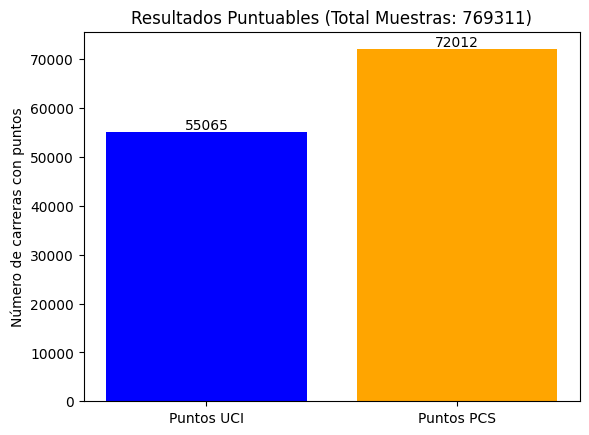

In [9]:
#Muestra una grafica sobre la cantidad de muestras con puntos > 0 que hay en cada sistema de puntuacion
conteo_uci_vs_pcs(ciclistas)

# DIVIDIR EL DATASET EN TRAIN/VAL/TEST

### 1.CREAR DATASET DE PREDICCION

In [5]:
datos_final = pd.read_csv('datos_final.csv', sep=';', decimal=',')

###Crea un dataset en el que en cada fila encontramos las estadisticas necesarias para predecir del ciclista:
###estadisticas de 2 años anteriores + variables objetivo(puntos individuales y puntos equipo)

###Se utiliza en el caso de querer añadir la variable edad
#prediccion_dataset = crear_dataset_prediccion(datos_final_con_edad)

prediccion_dataset = crear_dataset_prediccion(datos_final)

###Se utiliza en el caso de querer tener en cuenta las ultimas temporadas
#prediccion_dataset = crear_dataset_prediccion_3_temporadas(datos_final)

print(prediccion_dataset)

prediccion_dataset.to_csv('dataset_prediccion.csv', index=False, sep=';', decimal=',')

                     nombre   año  puntos_t  e_puntos_t  num_carreras_t-1  \
0      AAEN JØRGENSEN Jonas  2019      10.0       195.0                27   
1           AALERUD Katrine  2019      38.0       278.0                11   
2           AALERUD Katrine  2020     107.0       300.0                30   
3           AALERUD Katrine  2021     139.0       975.0                14   
4           AALERUD Katrine  2022      42.0      1007.0                24   
...                     ...   ...       ...         ...               ...   
15937       ZORDAN Giovanni  2023       0.0        51.0                 4   
15938          ZWAAN Sophia  2023       0.0       456.0                13   
15939          ÅHNBERG Carl  2023       0.0         0.0                 4   
15940     ČONTOFALSKÝ Marek  2023       0.0         0.0                 0   
15941         ŠIROKÝ Štěpán  2023       0.0         0.0                 2   

       num_carreras_t-2  puntos_t-1  puntos_t-2  top1_t-1  top1_t-2  ...  \

### 2.DIVIDIR EL DATASET

In [3]:
data = pd.read_csv('dataset_prediccion.csv', sep=';', decimal=',')

###Divide el dataset en 3 particiones:Train(2017-2021), Validacion(2022) y Test(2023)
train_data,val_data,test_data = dividir_dataset(data,año_limite_train=2021,año_limite_val=2022)
print("Train:",len(train_data)," Val:",len(val_data)," Test:",len(test_data))

datos = dividir_en_conjuntos(train_data,val_data,test_data)

###Opcion 1:conocer puntos del ciclista a partir de sus datos
X_train_1, y_train_1, X_val_1, y_val_1,X_test_1,y_test_1 = datos[0]

###Opcion 2:conocer los puntos que aporta al equipo a partir de la informacion del equipo
X_train_2, y_train_2, X_val_2, y_val_2,X_test_2, y_test_2 = datos[1]

###Opcion 3:conocer los puntos del ciclista teniendo en cuenta todos los datos
X_train_3, y_train_3, X_val_3, y_val_3,X_test_3, y_test_3 = datos[2]

###Opcion 4:conocer los puntos que aporta al equipo teniendo en cuenta todos los datos
X_train_4, y_train_4, X_val_4, y_val_4,X_test_4, y_test_4 = datos[3]

Train: 9234  Val: 2826  Test: 3882


# PREDECIR UTILIZANDO DIFERENTES MODELOS

### 1.PREDICCION INICIAL

Opcion 1:conocer puntos del ciclista a partir de sus datos



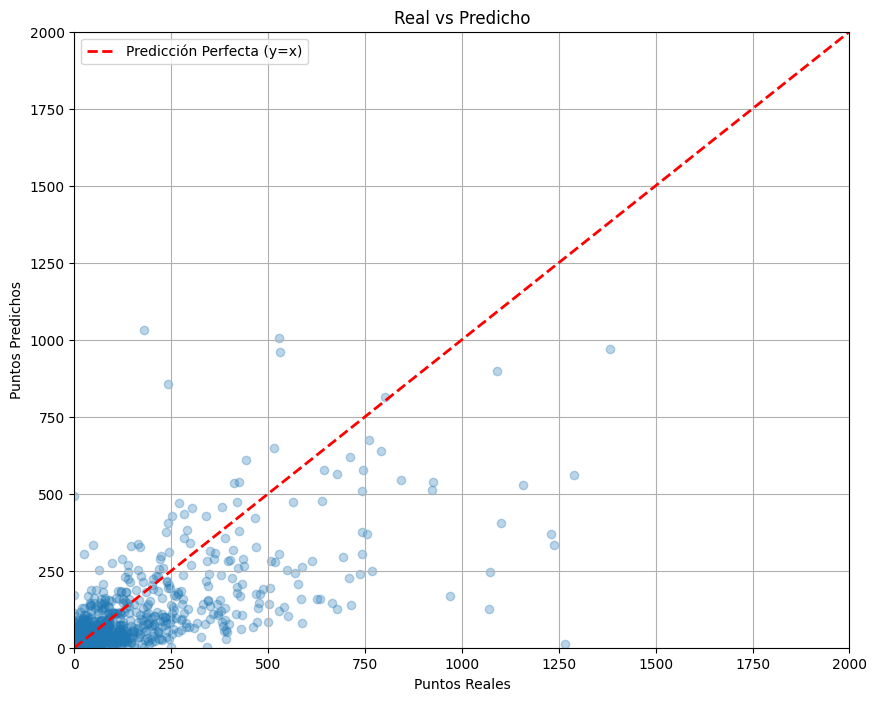

                           MAE    MAPE       MSE    R2  Spearmanr  \
Gradient Boosting        32.63  122.58   8938.46  0.56       0.76   
MLP                      32.47  123.76   8877.23  0.56       0.76   
Random Forest            32.85  136.74   8741.44  0.57       0.72   
Support Vector Machines  37.56   92.87  15387.28  0.25       0.70   
Regresion Lineal         33.39  118.53   8992.51  0.56       0.69   
KNN                      35.43  129.48  10259.15  0.50       0.66   
Decision Tree            40.20  159.14  12703.25  0.38       0.47   

                         Acc_Within_1  
Gradient Boosting               69.21  
MLP                             55.13  
Random Forest                   55.52  
Support Vector Machines         57.68  
Regresion Lineal                56.19  
KNN                             50.46  
Decision Tree                   52.37  



Opcion 2:conocer los puntos que aporta al equipo a partir de los puntos del equipo



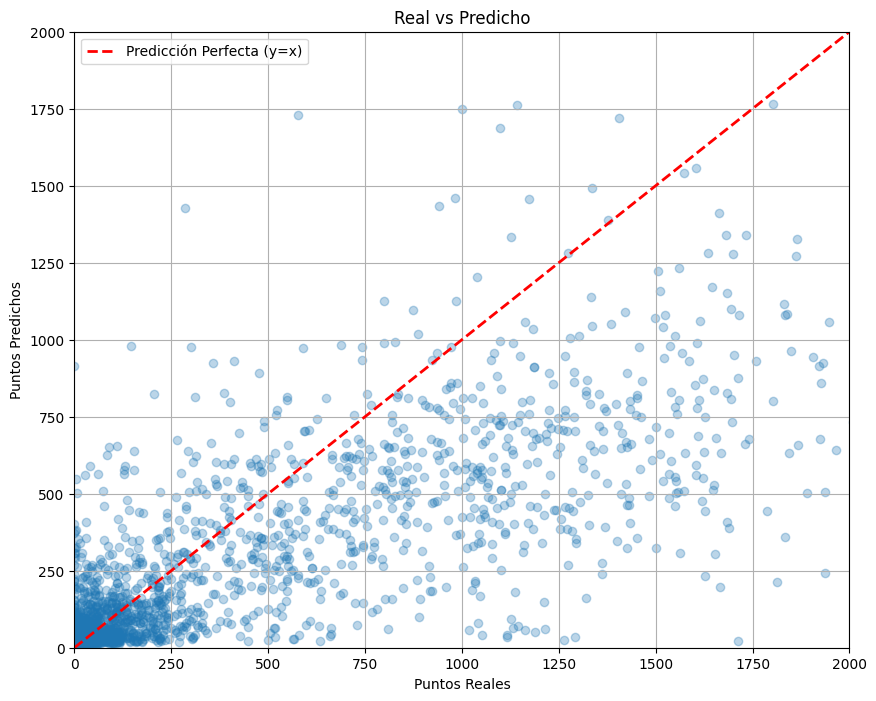

                            MAE    MAPE        MSE    R2  Spearmanr  \
Support Vector Machines  205.71  151.52  184981.01  0.36       0.82   
Gradient Boosting        178.80  397.44  127849.32  0.56       0.82   
MLP                      181.27  319.50  135311.42  0.53       0.82   
Regresion Lineal         188.89  453.81  135594.95  0.53       0.81   
Random Forest            186.03  470.36  129030.46  0.55       0.78   
KNN                      189.13  419.77  134003.26  0.53       0.74   
Decision Tree            233.20  482.85  198227.54  0.31       0.58   

                         Acc_Within_1  
Support Vector Machines         69.78  
Gradient Boosting               69.43  
MLP                             68.97  
Regresion Lineal                68.19  
Random Forest                   64.44  
KNN                             63.38  
Decision Tree                   48.94  



Opcion 3:conocer los puntos del ciclista teniendo en cuenta todos los datos



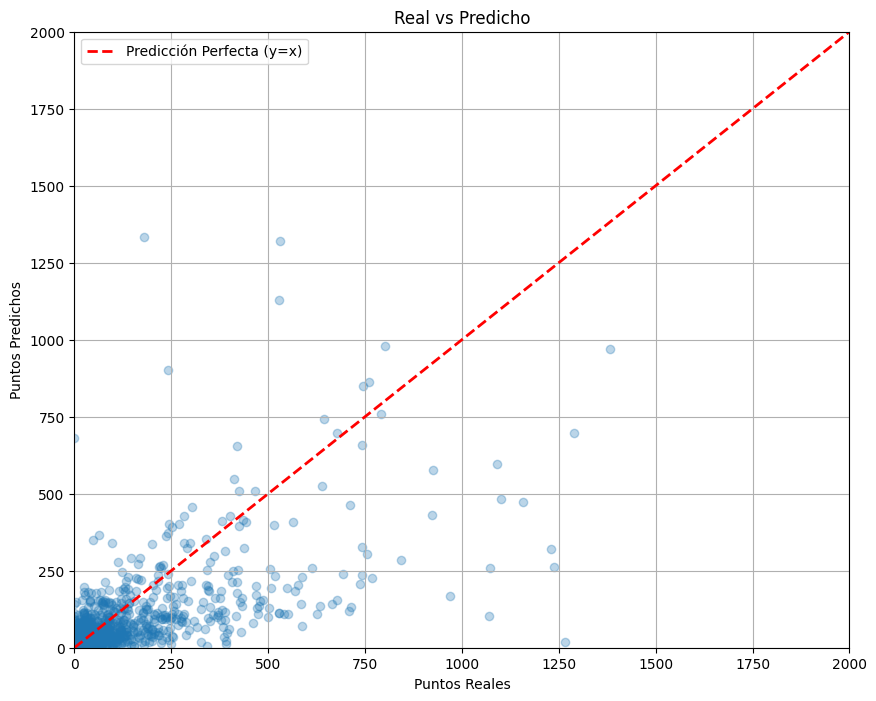

                           MAE    MAPE       MSE    R2  Spearmanr  \
Gradient Boosting        32.80  127.07   9123.03  0.55       0.77   
Random Forest            32.87  142.50   8894.65  0.56       0.76   
MLP                      34.03  142.03   9965.29  0.51       0.74   
Support Vector Machines  40.59  102.98  17574.27  0.14       0.73   
KNN                      35.25  146.98   9705.74  0.52       0.69   
Regresion Lineal         33.57  118.45   9038.81  0.56       0.65   
Decision Tree            40.84  176.07  12290.35  0.40       0.54   

                         Acc_Within_1  
Gradient Boosting               58.70  
Random Forest                   54.85  
MLP                             55.48  
Support Vector Machines         57.32  
KNN                             50.50  
Regresion Lineal                56.58  
Decision Tree                   57.89  



Opcion 4:conocer los puntos que aporta al equipo teniendo en cuenta todos los datos



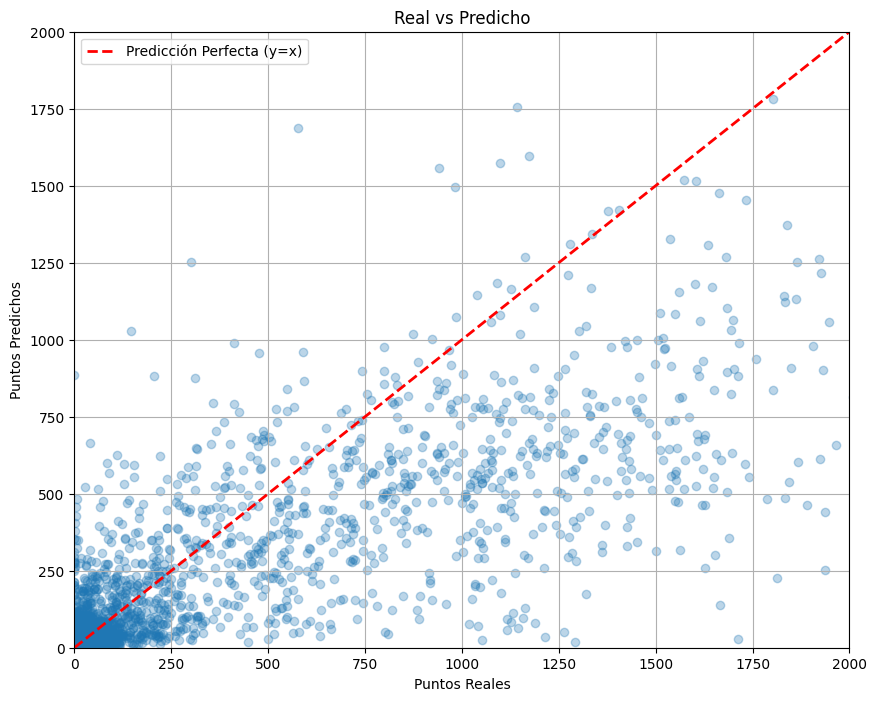

                            MAE    MAPE        MSE    R2  Spearmanr  \
Support Vector Machines  205.97  149.39  185738.17  0.36       0.83   
Gradient Boosting        176.76  355.99  126303.06  0.56       0.82   
MLP                      180.65  299.82  134625.71  0.53       0.81   
Random Forest            180.46  412.43  125855.42  0.56       0.80   
Regresion Lineal         187.34  393.79  136219.59  0.53       0.78   
KNN                      183.91  317.22  135171.77  0.53       0.76   
Decision Tree            227.33  433.95  200705.83  0.30       0.66   

                         Acc_Within_1  
Support Vector Machines         69.04  
Gradient Boosting               68.75  
MLP                             65.75  
Random Forest                   64.54  
Regresion Lineal                65.46  
KNN                             60.16  
Decision Tree                   52.65  





In [7]:
modelos = {
    "Regresion Lineal" : LinearRegression(),
    "Decision Tree" : DecisionTreeRegressor(random_state = 1),
    "Random Forest" : RandomForestRegressor(random_state = 1),
    "Gradient Boosting" : GradientBoostingRegressor(random_state = 1),
    "KNN" : KNeighborsRegressor(),
    "Support Vector Machines" : SVR(),
    "MLP" : MLPRegressor(random_state=1,max_iter=500)}

datos_prediccion = [
    (X_train_1, y_train_1, X_val_1, y_val_1),
    (X_train_2, y_train_2, X_val_2, y_val_2),
    (X_train_3, y_train_3, X_val_3, y_val_3),
    (X_train_4, y_train_4, X_val_4, y_val_4)
]

res1, res2, res3, res4 = realizar_prediccion(datos_prediccion, modelos)

### 2. BALANCEO DE DATASET

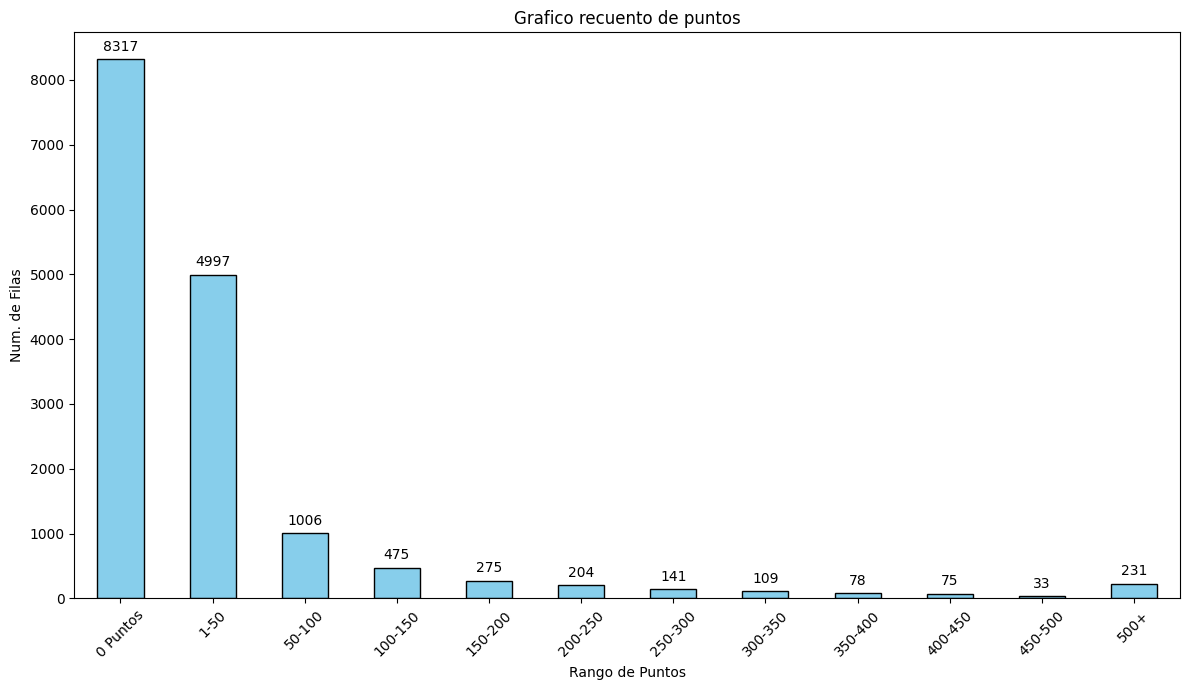

In [8]:
grafico_recuento_puntos('dataset_prediccion.csv')

In [4]:
print(f"Tamaño original de 'train_data': {len(train_data)} filas")

filas_con_puntos = train_data[train_data['puntos_t'] > 0]
filas_cero_puntos = train_data[train_data['puntos_t'] == 0]

print(f"Muestras con puntos (> 0): {len(filas_con_puntos)}")
print(f"Muestras con 0 puntos:   {len(filas_cero_puntos)}")

#n_ceros_a_mantener = len(filas_con_puntos)
n_ceros_a_mantener = len(filas_con_puntos) // 2
#n_ceros_a_mantener = len(filas_con_puntos) // 4

if n_ceros_a_mantener > len(filas_cero_puntos):
    n_ceros_a_mantener = len(filas_cero_puntos)

print(f"Se mantendrán {n_ceros_a_mantener} muestras de 0 puntos (al azar).")

filas_cero_sample = filas_cero_puntos.sample(n=n_ceros_a_mantener, random_state=42)

train_data_balanceado = pd.concat([filas_con_puntos, filas_cero_sample])

train_data_balanceado = train_data_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nNuevo 'train_data_balanceado' creado: {len(train_data_balanceado)} filas")


Tamaño original de 'train_data': 9234 filas
Muestras con puntos (> 0): 4381
Muestras con 0 puntos:   4853
Se mantendrán 2190 muestras de 0 puntos (al azar).

Nuevo 'train_data_balanceado' creado: 6571 filas


Opcion 1:conocer puntos del ciclista a partir de sus datos



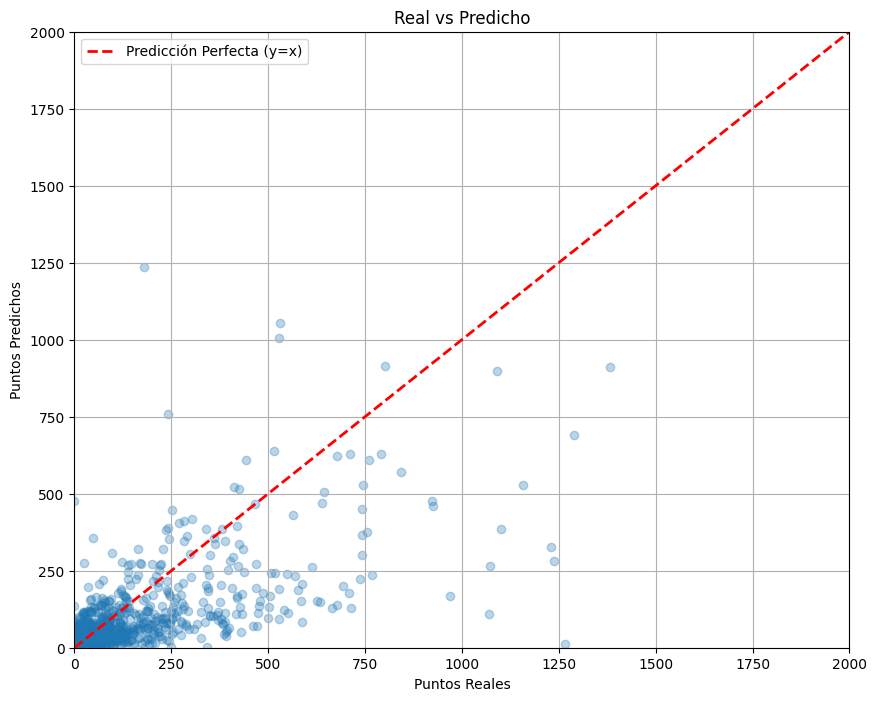

                           MAE    MAPE       MSE    R2  Spearmanr  \
Gradient Boosting        33.72  147.54   8755.61  0.57       0.76   
Support Vector Machines  37.08   92.30  15139.14  0.26       0.75   
MLP                      33.39  137.56   9298.54  0.54       0.73   
Random Forest            33.49  157.81   8791.72  0.57       0.73   
KNN                      35.94  145.76  10212.18  0.50       0.68   
Regresion Lineal         35.17  148.30   8951.21  0.56       0.66   
Decision Tree            41.83  175.06  13463.96  0.34       0.52   

                         Acc_Within_1  
Gradient Boosting               71.59  
Support Vector Machines         56.51  
MLP                             54.85  
Random Forest                   54.99  
KNN                             51.63  
Regresion Lineal                55.87  
Decision Tree                   51.45  



Opcion 2:conocer los puntos que aporta al equipo a partir de los puntos del equipo



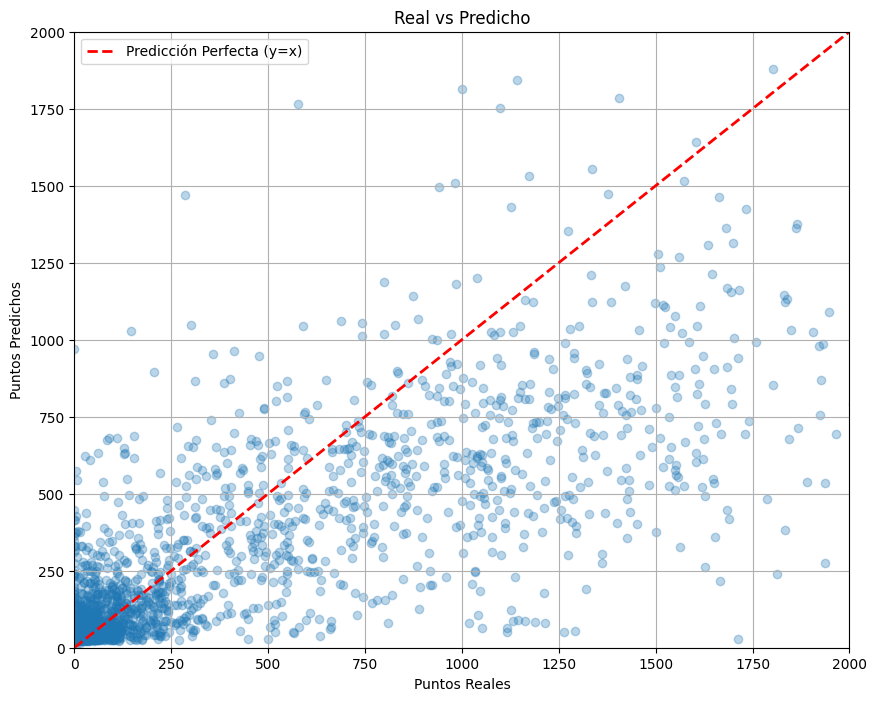

                            MAE    MAPE        MSE    R2  Spearmanr  \
Support Vector Machines  202.84  178.45  179447.28  0.38       0.82   
Gradient Boosting        181.56  511.52  122720.85  0.57       0.82   
MLP                      181.07  434.38  126791.18  0.56       0.82   
Regresion Lineal         197.93  648.45  132671.09  0.54       0.80   
Random Forest            191.99  605.90  127550.79  0.56       0.78   
KNN                      192.14  539.49  130151.03  0.55       0.75   
Decision Tree            241.51  581.91  208941.41  0.27       0.60   

                         Acc_Within_1  
Support Vector Machines         69.67  
Gradient Boosting               68.68  
MLP                             68.29  
Regresion Lineal                66.95  
Random Forest                   62.63  
KNN                             60.47  
Decision Tree                   48.90  



Opcion 3:conocer los puntos del ciclista teniendo en cuenta todos los datos



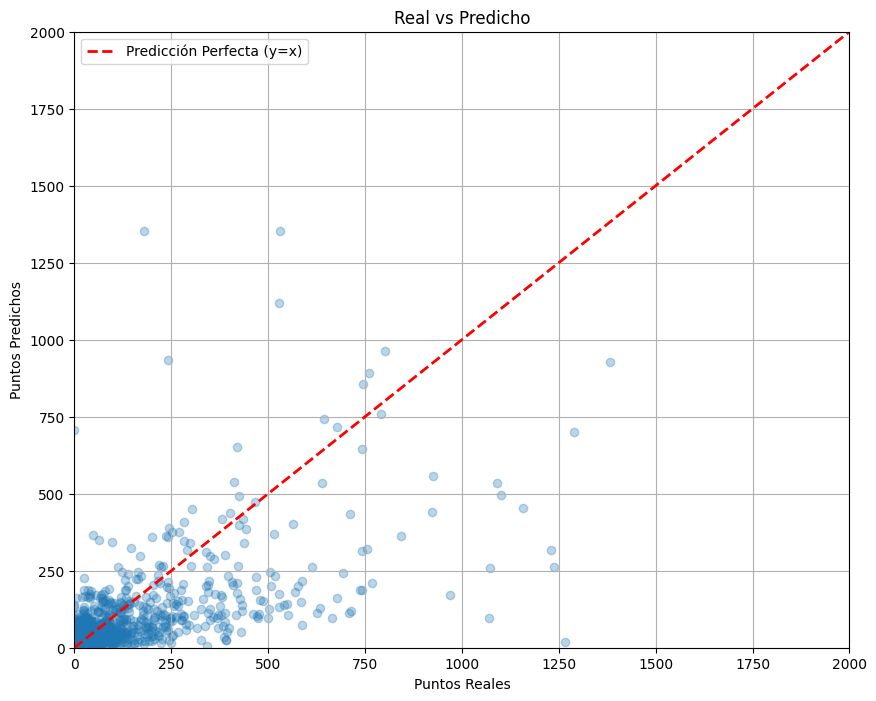

                           MAE    MAPE       MSE    R2  Spearmanr  \
Gradient Boosting        33.96  150.40   9006.90  0.56       0.76   
Support Vector Machines  40.22  107.85  17306.85  0.15       0.76   
Random Forest            33.52  163.06   8629.51  0.58       0.75   
MLP                      35.26  164.17  10092.54  0.50       0.73   
KNN                      36.08  167.06   9644.65  0.53       0.69   
Regresion Lineal         35.33  146.05   9001.43  0.56       0.62   
Decision Tree            44.16  204.44  13363.06  0.34       0.55   

                         Acc_Within_1  
Gradient Boosting               59.52  
Support Vector Machines         53.79  
Random Forest                   54.95  
MLP                             53.96  
KNN                             51.80  
Regresion Lineal                56.05  
Decision Tree                   55.17  



Opcion 4:conocer los puntos que aporta al equipo teniendo en cuenta todos los datos



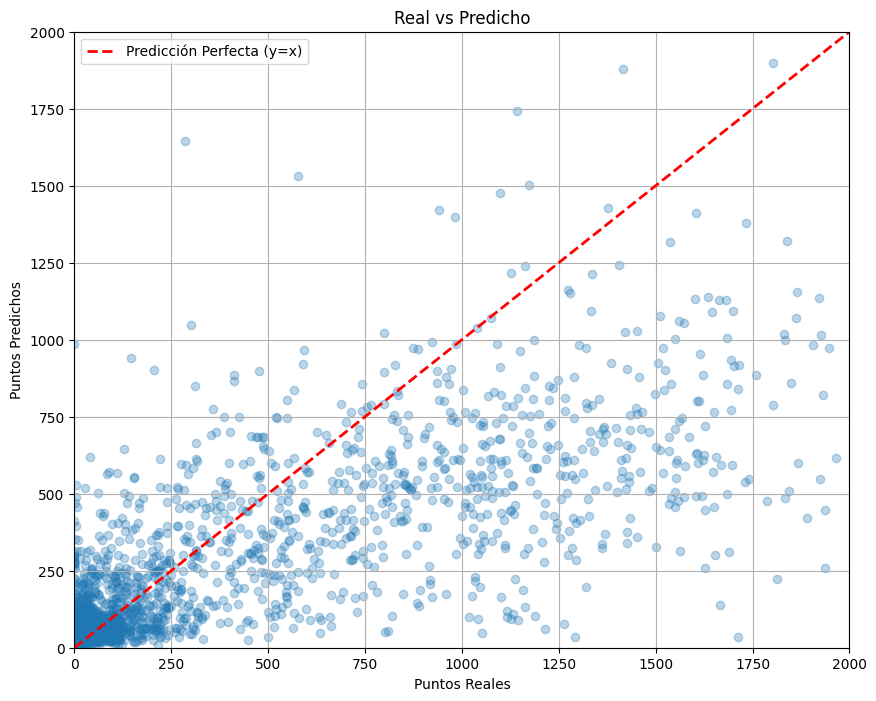

                            MAE    MAPE        MSE    R2  Spearmanr  \
Support Vector Machines  203.42  175.69  180736.57  0.37       0.83   
Gradient Boosting        179.40  462.71  123431.57  0.57       0.82   
MLP                      189.67  411.56  140397.23  0.51       0.81   
Random Forest            181.93  495.50  122207.69  0.58       0.80   
KNN                      183.47  385.49  129559.23  0.55       0.77   
Regresion Lineal         195.27  575.24  133775.15  0.54       0.77   
Decision Tree            235.82  609.44  200739.25  0.30       0.66   

                         Acc_Within_1  
Support Vector Machines         69.07  
Gradient Boosting               68.15  
MLP                             65.29  
Random Forest                   64.37  
KNN                             61.57  
Regresion Lineal                64.72  
Decision Tree                   52.58  





In [5]:
modelos = {
    "Regresion Lineal" : LinearRegression(),
    "Decision Tree" : DecisionTreeRegressor(random_state = 1),
    "Random Forest" : RandomForestRegressor(random_state = 1),
    "Gradient Boosting" : GradientBoostingRegressor(random_state = 1),
    "KNN" : KNeighborsRegressor(),
    "Support Vector Machines" : SVR(),
    "MLP" : MLPRegressor(random_state=1,max_iter=500)}

datos = dividir_en_conjuntos(train_data_balanceado,val_data,test_data)

###Opcion 1:conocer puntos del ciclista a partir de sus datos
X_train_1b, y_train_1b, X_val_1, y_val_1,X_test_1,y_test_1 = datos[0]

###Opcion 2:conocer los puntos que aporta al equipo a partir de la informacion del equipo
X_train_2b, y_train_2b, X_val_2, y_val_2,X_test_2, y_test_2 = datos[1]

###Opcion 3:conocer los puntos del ciclista teniendo en cuenta todos los datos
X_train_3b, y_train_3b, X_val_3, y_val_3,X_test_3, y_test_3 = datos[2]

###Opcion 4:conocer los puntos que aporta al equipo teniendo en cuenta todos los datos
X_train_4b, y_train_4b, X_val_4, y_val_4,X_test_4, y_test_4 = datos[3]

datos_prediccion_balanceado = [
    (X_train_1b, y_train_1b, X_val_1, y_val_1),
    (X_train_2b, y_train_2b, X_val_2, y_val_2),
    (X_train_3b, y_train_3b, X_val_3, y_val_3),
    (X_train_4b, y_train_4b, X_val_4, y_val_4)
]

res1, res2, res3, res4 = realizar_prediccion(datos_prediccion_balanceado, modelos)


### 3.UTILIZACION GRID SEARCH

In [6]:
#1.definir los posibles hiperparametros
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

mlp_params = {
    'mlp__hidden_layer_sizes': [(50,50), (100,), (100,50)], 
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}

svr_params = {
    'svr__C': [1, 5, 10, 20],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__gamma': ['scale', 'auto', 0.1, 0.01],
    'svr__kernel': ['rbf']
}

#2.Ejecutar el GridSearch
print("\nINICIANDO BÚSQUEDA DE HIPERPARÁMETROS \n")

# 1. Gradient Boosting 
gb_opt = ejecutar_grid_search(
    GradientBoostingRegressor(random_state=1), 
    gb_params, X_train_3b, y_train_3b, "Gradient Boosting", "MAE"
)

# 2. Random Forest
rf_opt = ejecutar_grid_search(
    RandomForestRegressor(random_state=1), 
    rf_params, X_train_3b, y_train_3b, "Random Forest", "MAE"
)
# 3.MLP
pipe_mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(random_state=1, max_iter=500))])
mlp_opt = ejecutar_grid_search(
    pipe_mlp, mlp_params, X_train_3b, y_train_3b, "MLP (Neural Network)", "MAE"
)
# 4. SVR 
pipe_svr = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
svr_opt = ejecutar_grid_search(
    pipe_svr, svr_params, X_train_3b, y_train_3b, "SVR", "Spearman"
)

# Guardar los campeones
modelos_finales_optimizados = {
    "Gradient Boosting Opt": gb_opt,
    "Random Forest Opt": rf_opt,
    "MLP Opt": mlp_opt,
    "SVR Opt": svr_opt
}


INICIANDO BÚSQUEDA DE HIPERPARÁMETROS 

OPTIMIZANDO: Gradient Boosting
Objetivo: Maximizar MAE
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Mejor MAE (Validación Cruzada): 38.8104
--------------------------------------------------
OPTIMIZANDO: Random Forest
Objetivo: Maximizar MAE
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}
Mejor MAE (Validación Cruzada): 38.3865
--------------------------------------------------
OPTIMIZANDO: MLP (Neural Network)
Objetivo: Maximizar MAE
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores parámetros: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.001}
Mejor MAE (Validación Cruzada): 38.7342
--------------------------------------------------
OPTIMIZANDO: SVR
Objetivo: Maximizar Spearman
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros: {'svr__C': 20, 'svr__epsilon': 0.1, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Mejor Spearman (Validación Cruzada): 0.7395
--------------------------------------------------


Opcion 1:conocer puntos del ciclista a partir de sus datos



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


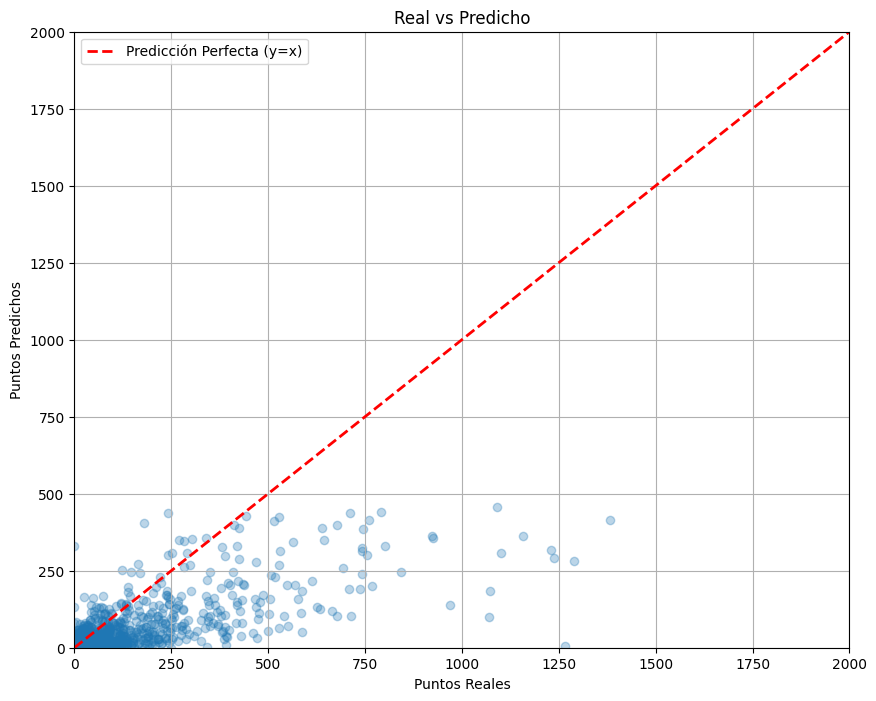

                         MAE    MAPE       MSE    R2  Spearmanr  Acc_Within_1
Gradient Boosting Opt  33.42  141.61   9090.51  0.55       0.76         67.59
Random Forest Opt      32.72  138.54   8709.83  0.57       0.76         55.31
SVR Opt                34.28   89.36  11960.43  0.41       0.75         55.84
MLP Opt                32.51  136.15   8526.03  0.58       0.71         57.78



Opcion 2:conocer los puntos que aporta al equipo a partir de los puntos del equipo



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


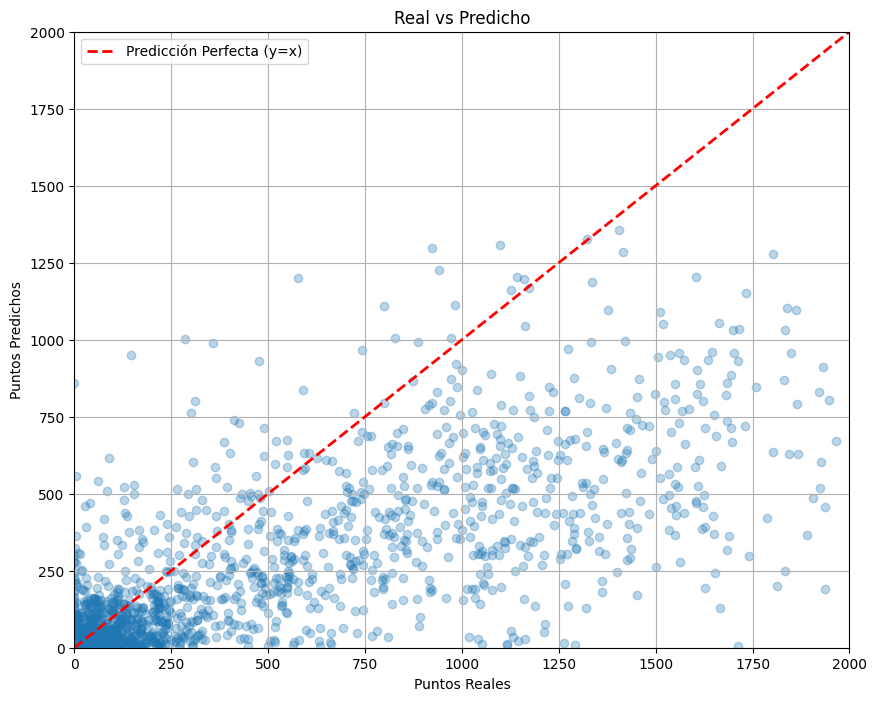

                          MAE    MAPE        MSE    R2  Spearmanr  \
SVR Opt                193.65  192.19  160361.22  0.44       0.82   
Gradient Boosting Opt  181.58  500.01  122870.56  0.57       0.82   
Random Forest Opt      182.83  515.40  121730.16  0.58       0.81   
MLP Opt                175.00  451.68  116849.94  0.59       0.80   

                       Acc_Within_1  
SVR Opt                       69.21  
Gradient Boosting Opt         68.75  
Random Forest Opt             66.74  
MLP Opt                       67.27  



Opcion 3:conocer los puntos del ciclista teniendo en cuenta todos los datos



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


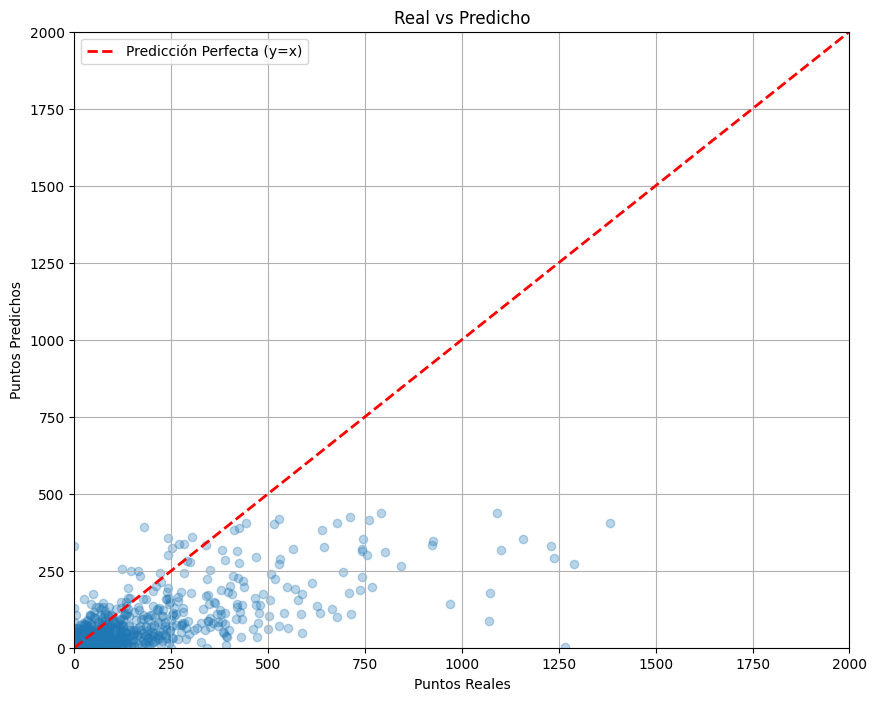

                         MAE    MAPE       MSE    R2  Spearmanr  Acc_Within_1
Random Forest Opt      32.64  145.11   8702.40  0.57       0.78         56.16
Gradient Boosting Opt  33.88  147.99   9136.69  0.55       0.77         53.79
SVR Opt                33.95   93.15  11974.64  0.41       0.77         56.86
MLP Opt                32.52  153.27   8448.75  0.59       0.70         58.56



Opcion 4:conocer los puntos que aporta al equipo teniendo en cuenta todos los datos



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


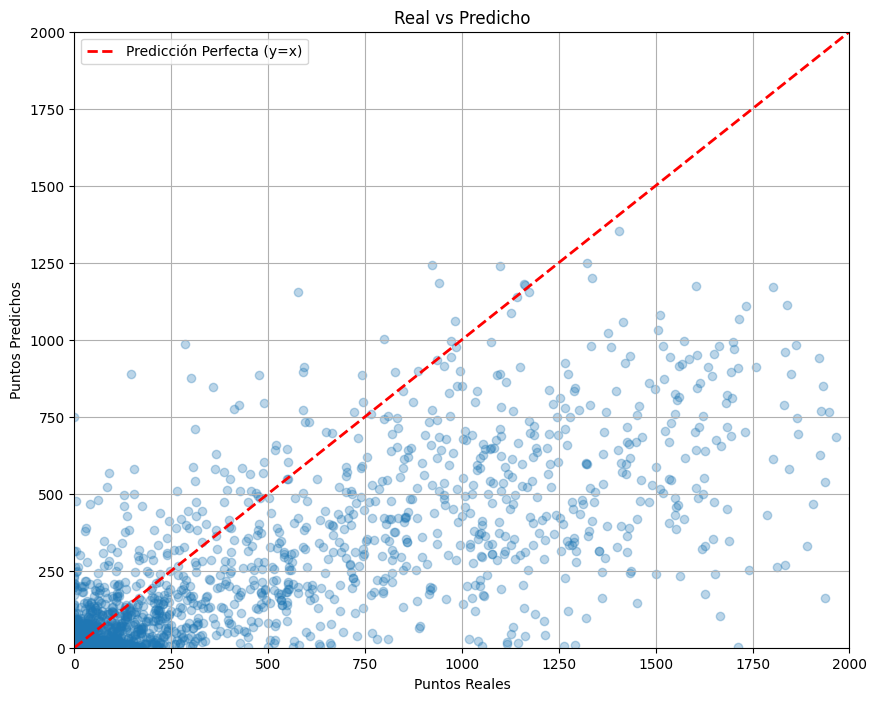

                          MAE    MAPE        MSE    R2  Spearmanr  \
Random Forest Opt      178.08  436.24  120824.65  0.58       0.82   
SVR Opt                192.67  163.29  159879.05  0.44       0.82   
Gradient Boosting Opt  179.92  448.54  122125.48  0.58       0.82   
MLP Opt                173.56  390.12  118816.50  0.59       0.82   

                       Acc_Within_1  
Random Forest Opt             67.30  
SVR Opt                       67.98  
Gradient Boosting Opt         68.15  
MLP Opt                       67.34  





In [13]:
datos_prediccion_balanceado = [
    (X_train_1b, y_train_1b, X_val_1, y_val_1),
    (X_train_2b, y_train_2b, X_val_2, y_val_2),
    (X_train_3b, y_train_3b, X_val_3, y_val_3),
    (X_train_4b, y_train_4b, X_val_4, y_val_4)
]

res1, res2, res3, res4 = realizar_prediccion(datos_prediccion_balanceado, modelos_finales_optimizados)

### 4.MODELO FINAL

Opcion 1:conocer puntos del ciclista a partir de sus datos



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


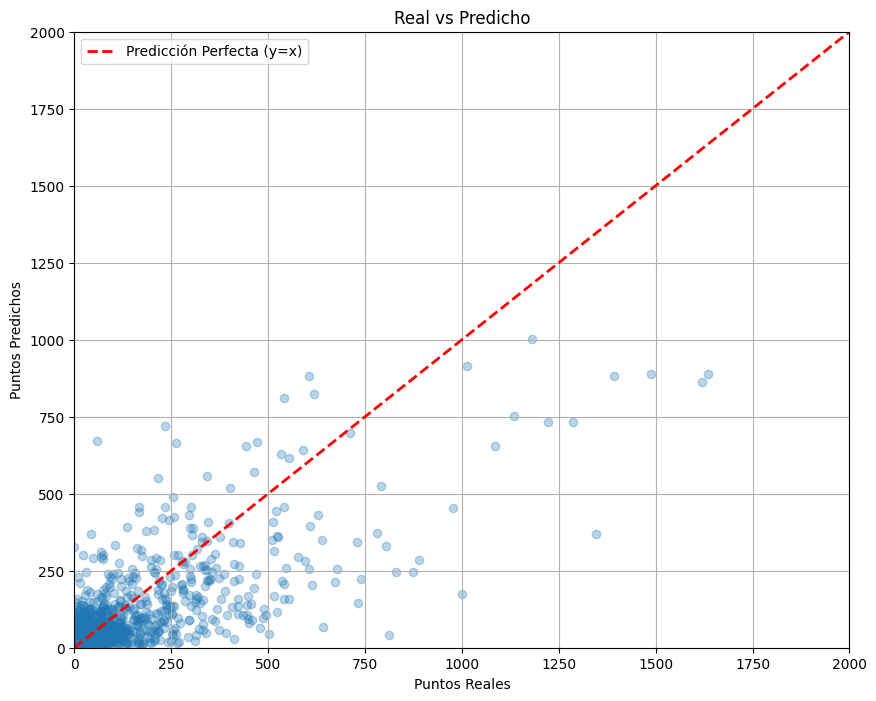

                     MAE    MAPE      MSE    R2  Spearmanr  Acc_Within_1
Random Forest Opt  27.47  163.37  6277.67  0.62       0.75         50.49
MLP Opt            26.97  156.32  5756.35  0.65       0.70         55.05



Opcion 2:conocer los puntos que aporta al equipo a partir de los puntos del equipo



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


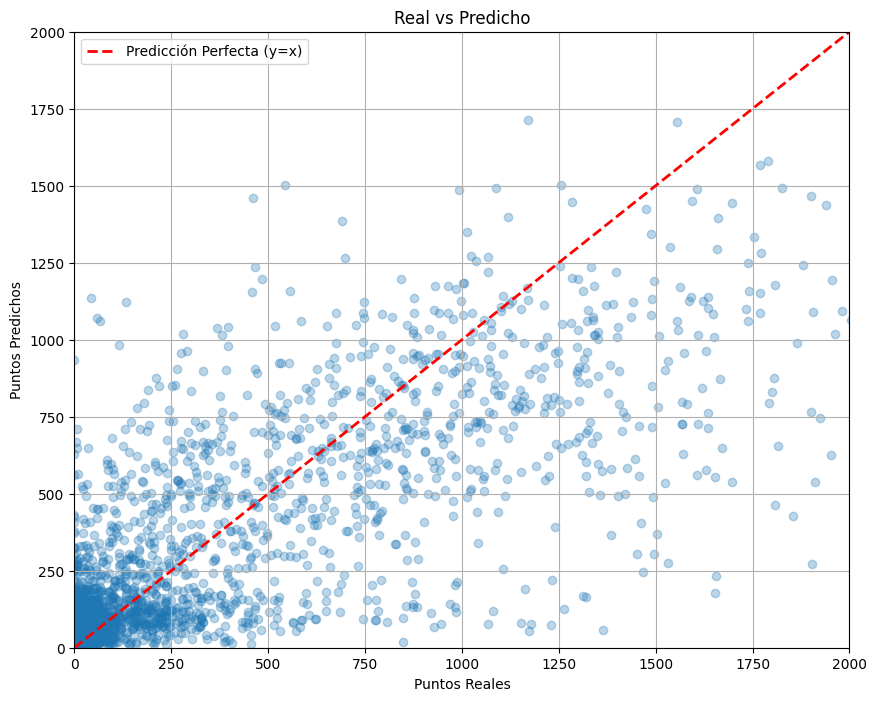

                      MAE    MAPE       MSE    R2  Spearmanr  Acc_Within_1
Random Forest Opt  149.45  509.65  93685.67  0.63       0.78         65.30
MLP Opt            143.97  457.43  87021.20  0.66       0.76         64.58



Opcion 3:conocer los puntos del ciclista teniendo en cuenta todos los datos



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


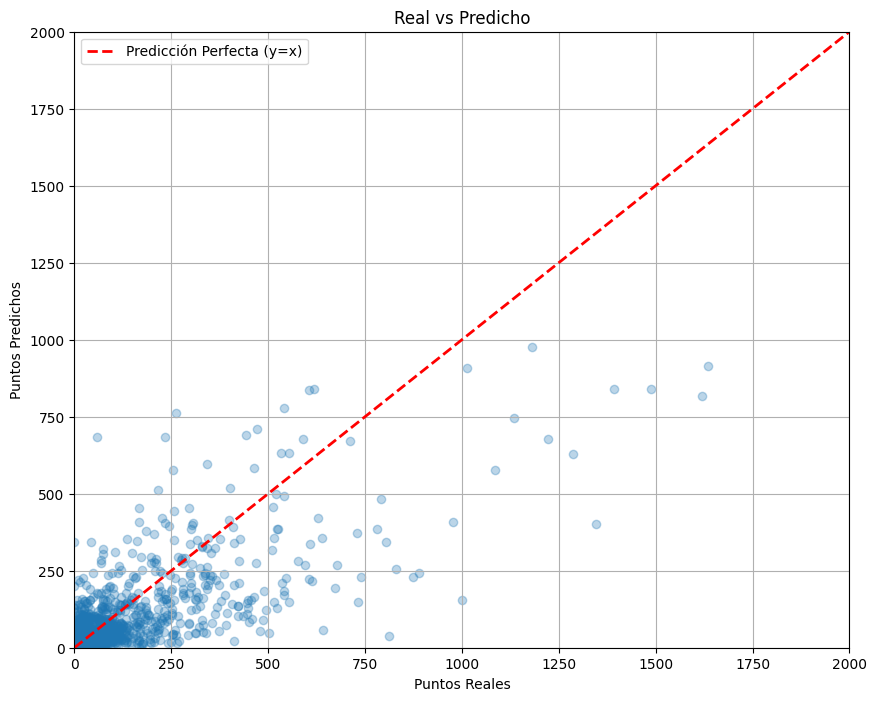

                     MAE    MAPE      MSE    R2  Spearmanr  Acc_Within_1
Random Forest Opt  27.52  162.67  6340.22  0.61       0.75         51.34
MLP Opt            27.28  170.21  5659.98  0.65       0.66         56.44



Opcion 4:conocer los puntos que aporta al equipo teniendo en cuenta todos los datos



C:\Users\Iker\jupyter_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


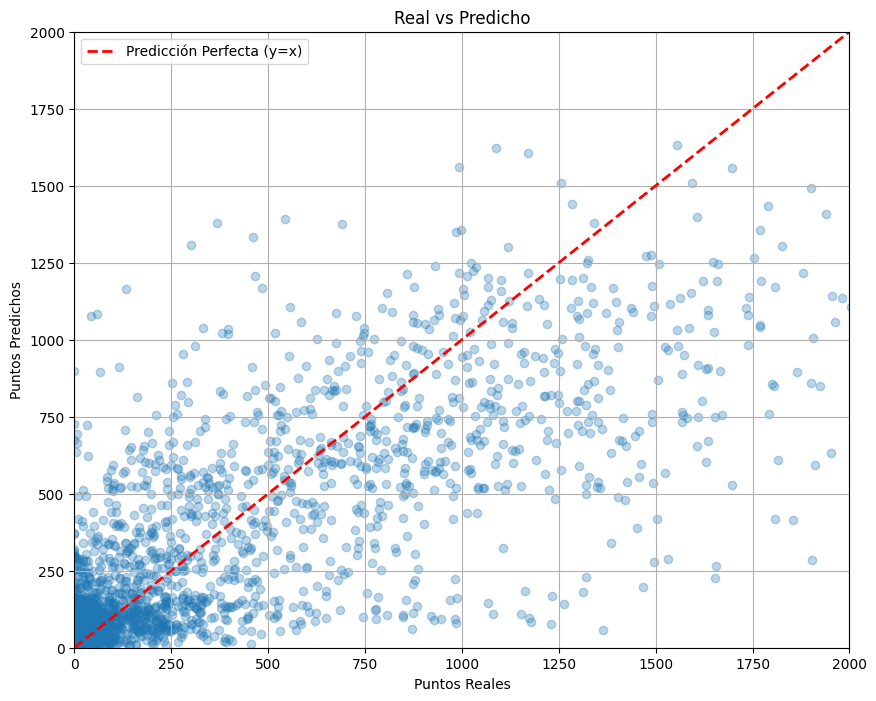

                      MAE    MAPE       MSE    R2  Spearmanr  Acc_Within_1
MLP Opt            138.71  394.48  83841.23  0.67        0.8         64.71
Random Forest Opt  144.16  427.88  91769.07  0.64        0.8         64.06





In [8]:
# 1. Seleccionamos SOLO los dos modelos campeones
modelos_finales_test = {
    "MLP Opt": mlp_opt,
    "Random Forest Opt": rf_opt
}


datos_para_test_final = [
    (X_train_1b, y_train_1b, X_test_1, y_test_1),
    (X_train_2b, y_train_2b, X_test_2, y_test_2),
    (X_train_3b, y_train_3b, X_test_3, y_test_3),
    (X_train_4b, y_train_4b, X_test_4, y_test_4)
]
# 3.Ejecutar
res_test_1, res_test_2, res_test_3, res_test_4 = realizar_prediccion(
    datos_para_test_final, 
    modelos_finales_test
)
